In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data_raw = pd.read_csv("train.csv")
print "Number of training data: %d" %len(train_data_raw)
train_data_raw.head(5)

Number of training data: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
test_data = pd.read_csv("test.csv")
print('Total number of question pairs for testing: {}'.format(len(test_data)))

Total number of question pairs for testing: 2345796


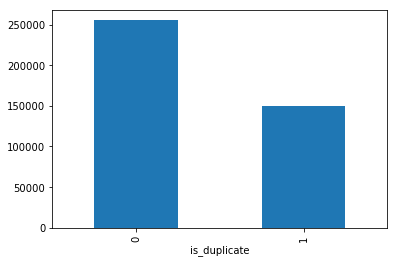

In [4]:
#Look at the distribution of duplicate or not
train_data_raw.groupby("is_duplicate")['id'].count().plot.bar()

In [5]:
#Select subset of data due to computing and memory limit of my laptop.
train_data_subset = train_data_raw[0:1000]
#Separate q1 and q2 into two dataframes
td_1 = train_data_subset[['qid1','question1']]
td_1.columns = ['qid1','question']
td_2 = train_data_subset[['qid2','question2']]
td_2.columns = ['qid2','question']
#Combine them together and fill NA with empty string. Now number of rows should double.
td = pd.concat((td_1,td_2),axis=0).fillna("")
td.shape

(2000, 3)

In [6]:
#Use TF-IDF to process strings
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 256)
td_processed = tfidf.fit_transform(td['question'])
td_processed

<2000x256 sparse matrix of type '<type 'numpy.float64'>'
	with 12327 stored elements in Compressed Sparse Row format>

In [7]:
#Calculate the 'distance' between question 1 and question 2
distance = np.abs(td_processed[::2] - td_processed[1::2])
distance

<1000x256 sparse matrix of type '<type 'numpy.float64'>'
	with 11548 stored elements in Compressed Sparse Row format>

In [8]:
#Construct features: character length, number of words, normalized word share 
train_data = train_data_raw
train_data['q1chrlen'] = train_data['question1'].str.len()
train_data['q2chrlen'] = train_data['question2'].str.len()
train_data['q1_nword'] = train_data['question1'].apply(lambda x: len(x.split(" ")))
train_data['q2_nword'] = train_data['question2'].apply(lambda y: len(str(y).split(" ")))

def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), x['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

train_data['word_share'] = train_data.apply(word_share_norm, axis=1)
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57.0,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88.0,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59.0,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65.0,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39.0,13,7,0.100000


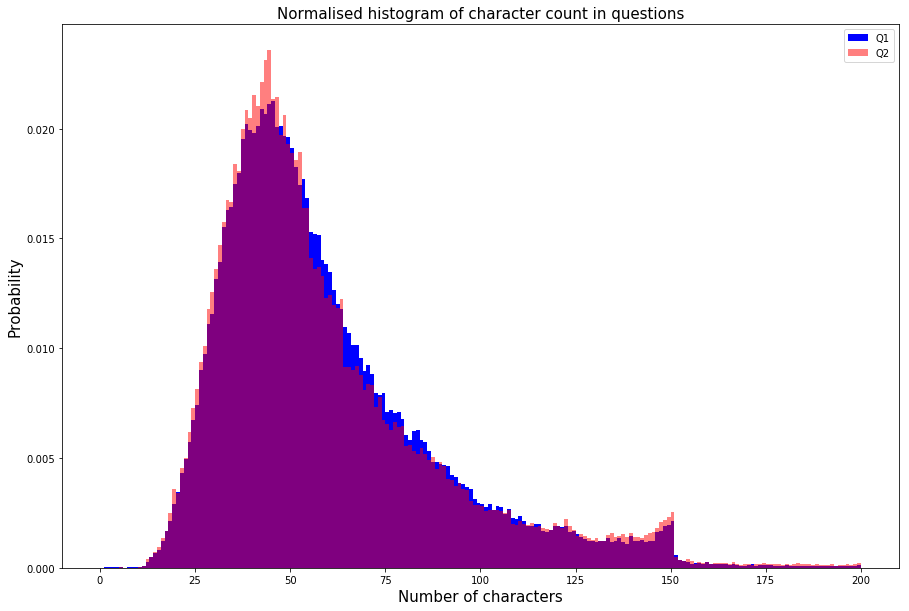

In [15]:
#Get some visual
plt.figure(figsize=(15, 10))
plt.hist(train_data['q1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='Q1')
plt.hist(train_data['q2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)